Building the Text Generator
The text generator can be built in the following simple steps:

Step 1. Import Necessary Libraries

Foremost, we need to import the necessary libraries. We are going to use TensorFlow with Keras for building the Bidirectional LSTM.

In case any of the mentioned libraries are not installed, then just install it with pip install [package-name] command in the terminal.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.utils as ku
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers


Step 2. Loading the Dataset and Exploratory Data Analysis

Now, we’ll load our dataset using pandas. Further, we need to perform some Exploratory Data Analysis so that we get to know our data better. As we are dealing with text data, the best way to do so is by generating a word cloud.

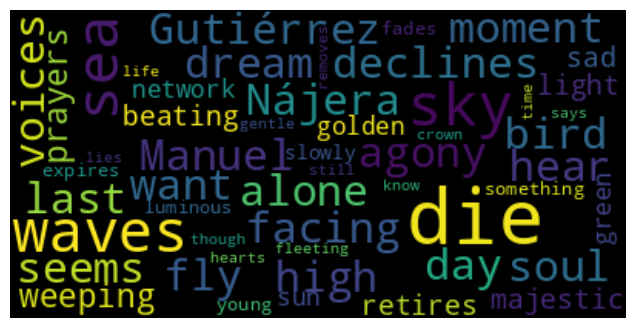

In [3]:
# Reading the text data file
data = open('/content/poem.txt', encoding="utf8").read()

# EDA: Generating WordCloud to visualize
# the text
wordcloud = WordCloud(max_font_size=50,
					max_words=100,
					background_color="black").generate(data)

# Plotting the WordCloud
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("WordCloud.png")
plt.show()


Step 3. Creating the Corpus

Now, we have all our data present in this massive text file. However, it is not recommended to feed our model with all the data altogether as it would lead to a lesser accuracy. Thus, we will be splitting our text into lines so that we can use them to generate text embeddings for our model.

In [4]:
# Generating the corpus by
# splitting the text into lines
corpus = data.lower().split("\n")
print(corpus[:10])


[' by manuel gutiérrez nájera', '', 'i want to die as the day declines, ', 'at high sea and facing the sky, ', 'while agony seems like a dream ', 'and my soul like a bird that can fly. ', '', 'to hear not, at this last moment, ', 'once alone with sky and sea, ', 'any more voices nor weeping prayers ']


Step 4. Fitting the Tokenizer on the Corpus

In order to generate the embeddings later, we need to fit a TensorFlow Tokenizer on the entire corpus so that it learns the vocabulary.  

In [5]:
# Fitting the Tokenizer on the Corpus
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

# Vocabulary count of the corpus
total_words = len(tokenizer.word_index)

print("Total Words:", total_words)


Total Words: 85


Step 5. Generating Embeddings/Vectorization

Now we will generate embeddings for each sentence in our corpus. Embeddings are vectorized representations of our text. Since we cannot feed Machine/Deep Learning models with unstructured text, this is an imperative step. Firstly, we convert each sentence to embedding using Keras’ text_to_sequence() function. Then we compute the length of the longest embedding; finally, we pad all the embeddings to that maximum length with zeros so as to ensure embeddings of equal length.



In [6]:
# Converting the text into embeddings
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]

	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences,
										maxlen=max_sequence_len,
										padding='pre'))
predictors, label = input_sequences[:, :-1], input_sequences[:, -1]
label = ku.to_categorical(label, num_classes=total_words+1)


This is how our text embeddings would look like:

array([[   0,    0,    0, …,    0,    0,  266],

       [   0,    0,    0, …,    0,  266,    3],

       [   0,    0,    0, …,    0,    0,    4],

       …,

       [   0,    0,    0, …,    8, 3807,   15],

       [   0,    0,    0, …, 3807,   15,    4],

       [   0,    0,    0, …,   15,    4,  203]], dtype=int32)

Step 6. Building the Bi-directional LSTM Model

By now, we are done with all the pre-processing steps that were required in order to feed the text to our model. Its time now that we start building the model. Since this is a use case of text generation, we will create a Bi-directional LSTM model as meaning plays an important role here.

In [7]:
# Building a Bi-Directional LSTM Model
model = Sequential()
model.add(Embedding(total_words+1, 100,
					input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words+1/2, activation='relu',
				kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words+1, activation='softmax'))
model.compile(loss='categorical_crossentropy',
			optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 8, 100)            8600      
                                                                 
 bidirectional (Bidirection  (None, 8, 300)            301200    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 8, 300)            0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 85)                8585      
                                                                 
 dense_1 (Dense)             (None, 86)                7396      
                                                        

The model will work on a next-word-prediction-based approach wherein we will input a seed text, and the model will generate poetry by predicting the subsequent words. This is why we have used a softmax activation function which is generally used for multi-class classification use cases.

Step 7. Model Training

Having built the model architecture, we’ll now train it on our pre-processed text. Here, we have trained our model for 150 Epochs.



In [8]:
history = model.fit(predictors, label, epochs=150, verbose=1)


Epoch 1/150
4/4 [==============================] - 8s 49ms/step - loss: 5.3532 - accuracy: 0.0103
Epoch 2/150
4/4 [==============================] - 0s 55ms/step - loss: 5.2881 - accuracy: 0.0515
Epoch 3/150
4/4 [==============================] - 0s 54ms/step - loss: 5.2283 - accuracy: 0.0619
Epoch 4/150
4/4 [==============================] - 0s 48ms/step - loss: 5.1711 - accuracy: 0.0825
Epoch 5/150
4/4 [==============================] - 0s 50ms/step - loss: 5.1153 - accuracy: 0.0825
Epoch 6/150
4/4 [==============================] - 0s 55ms/step - loss: 5.0578 - accuracy: 0.0825
Epoch 7/150
4/4 [==============================] - 0s 54ms/step - loss: 4.9943 - accuracy: 0.0825
Epoch 8/150
4/4 [==============================] - 0s 55ms/step - loss: 4.8943 - accuracy: 0.0825
Epoch 9/150
4/4 [==============================] - 0s 51ms/step - loss: 4.7642 - accuracy: 0.0825
Epoch 10/150
4/4 [==============================] - 0s 54ms/step - loss: 4.7672 - accuracy: 0.0825
Epoch 11/150
4/4 [=

Step 8. Generating Text using the Built Model

In the final step, we will generate poetry using our model. As stated earlier, the model is based upon a next-word prediction approach – hence, we need to provide the model with some seed text.



In [10]:
seed_text = "The world"
next_words = 25
ouptut_text = ""

for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences(
		[token_list], maxlen=max_sequence_len-1,
	padding='pre')
	predicted = np.argmax(model.predict(token_list,
										verbose=0), axis=-1)
	output_word = ""

	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break

	seed_text += " " + output_word

print(seed_text)



The world like says a dream that slowly lies lies lies lies lies lies lies lies lies lies lies lies lies lies lies lies lies lies lies


Finally, we have built a model from scratch that generates poetry given an input seed text. The model can be made to generate even better results by using a larger training dataset and fiddling with the model parameters.




*Q*)1.  1. Implement the Edit Distance.

Given two strings str1 and str2 of length M and N respectively and below operations that can be performed on str1. Find the minimum number of edits (operations) to convert ‘str1‘ into ‘str2‘.  

Operation 1 (INSERT): Insert any character before or after any index of str1
Operation 2 (REMOVE): Remove a character of str1
Operation 3 (Replace): Replace a character at any index of str1 with some other character.
Note: All of the above operations are of equal cost.

Let’s suppose we have str1=”GEEXSFRGEEKKS” and str2=”GEEKSFORGEEKS”
Now to convert str1 into str2 we would require 3 minimum operations:
Operation 1: Replace ‘X‘ to ‘K‘
Operation 2: Insert ‘O‘ between ‘F‘ and ‘R‘
Operation 3: Remove second last character i.e. ‘K‘

In [11]:
def edit_distance(str1, str2):
    # Create a table to store results of subproblems
    dp = [[0] * (len(str2) + 1) for _ in range(len(str1) + 1)]

    # Initialize the first row and column
    for i in range(len(str1) + 1):
        dp[i][0] = i
    for j in range(len(str2) + 1):
        dp[0][j] = j

    # Fill the table using dynamic programming
    for i in range(1, len(str1) + 1):
        for j in range(1, len(str2) + 1):
            if str1[i - 1] == str2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = 1 + min(dp[i - 1][j],        # Deletion
                                   dp[i][j - 1],        # Insertion
                                   dp[i - 1][j - 1])    # Substitution

    # Return the minimum edit distance
    return dp[len(str1)][len(str2)]

# Example usage:
str1 = "kitten"
str2 = "sitting"
print("Edit Distance between '{}' and '{}' is: {}".format(str1, str2, edit_distance(str1, str2)))


Edit Distance between 'kitten' and 'sitting' is: 3
